<br>
<h1> Performance Metrics </h1>
<hr>
<h3> Portfolio Risk and Return Metrics </h3>
<br>
Assume that we have the benchmark, for simplicity assume a proxy for the S&P 500 Index, SPY ETF. We would like to calculate a few performance metrics:
<br>
<ol>
  <li>Rolling Annualized Return</li>
    <li>Rolling Excess Return</li>
  <li>Rolling Annualized Tracking Error</li>
   <li>Rolling Maximum Dollar (High-Water Mark)</li>
   <li>Batting Average</li>
      <li>Max Drawdown</li>
      <li>Upside Capture</li>
  <li>Downside Capture</li>
  <li>Annualized Return</li>
  <li>Annualized Volatility</li>
  <li>Annualized Sharpe</li>
  <li>Annualized Tracking Error</li>
  <li>Annualized Information Ratio</li>
  <li>Beta</li>


</ol>
<br>
Consider our "portfolio" to be the Vanguard Communication Services Index Fund ETF (VOX).
<br>

In [1]:
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import yfinance as yf
import numpy as np
from scipy.optimize import minimize
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import warnings
import waterfall_chart as waterfall

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [15, 8]
plt.style.use("seaborn-whitegrid")

***1. Rolling Annualized Returns***

In [2]:
def rolling_ret(df, n):
    """
    Inputs: returns dataframe (df), rolling window (n)
    Output: rolling returns dataframe
    """
    rolling_ret = (1+df).rolling(window=n).apply(np.prod, raw=True)**(12/n) -1
    return rolling_ret

***2. Rolling Annualized Excess Returns***

Also consider using geometric excess returns:
<br>
\begin{align}
Excess &= \frac{1 + Portfolio_{returns}}{1 + Benchmark_{returns}} - 1
\end{align}
<br><br>
<i>Note: this is virtually the same as rolling returns with the "df" input being the excess return instead of returns.</i>

In [3]:
def rolling_excess(df_port, df_bm, n):
    """
    Inputs: portfolio returns (df_port), benchmark returns (df_bm), rolling window (n)
    Output: rolling excess return dataframe
    """
    rolling_excess = ((1+df_port)/(1+df_bm)).rolling(window=n).apply(np.prod, raw=True)**(12/n) -1
    return rolling_excess

***3. Rolling Annualized Tracking Error***

We will continue to use the geometric excess return. Tracking error is defined as the standard deviation of excess returns:
<br>
<br>
\begin{align}
Tracking Error &= \sigma(Excess Returns) \sqrt{t}
\end{align}

In [4]:
def rolling_te(df_port, df_bm, n):
    """
    Inputs: portfolio returns (df_port), benchmark returns (df_bm), rolling window (n)
    Output: rolling tracking error dataframe
    """
    rolling_te = (((1+df_port)/(1+df_bm))-1).rolling(window=n).std()*np.sqrt(n)
    return rolling_te

***4. High-Water Mark***

In [5]:
def hwm(df):
    hwm = (1*(1+df).cumprod())
    hwm = hwm.cummax()
    return hwm

***5. Batting Average***
- For simplicity, consider the already calculated rolling returns (12 months)
- The batting average is the percentage of time that the portfolio has outperformed the benchmark (SPY), in this case on a rolling basis

In [6]:
def batting_average(df_port, df_bm, n):
    """
    Inputs: portfolio returns (df_port), benchmark returns (df_bm), rolling window (n)
    Output: rolling batting average
    """
    rolling_ret_port = (1+df_port).rolling(window=n).apply(np.prod, raw=True)**(12/n) -1
    rolling_ret_bm = (1+df_bm).rolling(window=n).apply(np.prod, raw=True)**(12/n) -1
    batting_average = sum(rolling_ret_port > rolling_ret_bm)/rolling_ret_bm.count()
    return batting_average

***6. Max Drawdown***
- Maximum Drawdown measures the largest price drop from a peak. To calculate the maximum drawdown of each asset, let's first calculate the drawdown.

In [7]:
def DD(df):
    """
    Inputs: price index dataframe (df)
    Output: Maximum Drawdown dataframe
    """
    df1 = pd.DataFrame(df)
    name = df1.columns.tolist()
    name = (", ".join(map(str, name)))
    Roll_Max = df.cummax()
    DD = (df/Roll_Max) - 1
    MDD = DD.min()
    print(f"{str(name)} Max Drawdown: {round(MDD*100,3)}%")
    return DD

***7. Upside Capture***
- Upside capture ratios for funds are calculated by taking the fund's monthly return during months when the benchmark had a positive return and dividing it by the benchmark return during that same month <a href=" https://www.morningstar.com/invglossary/upside-downside-capture-ratio.aspx#:~:text=Upside%20capture%20ratios%20for%20funds,return%20during%20that%20same%20month">(Morningstar® glossary of investing definitions)</a>

In [8]:
def upside_capute(df_port, df_bm):
    """
    Inputs: portfolio returns (df_port), benchmark returns (df_bm)
    Output: upside capture
    """
    df_port = pd.DataFrame(df_port)
    df_bm = pd.DataFrame(df_bm)
    df = df_port.join(df_bm)
    Up_BM = (np.product(1+df[df.iloc[:,1]>0].iloc[:,1])**(12/((df[df.iloc[:,1]>0].iloc[:,1].count()))))-1
    Up_Port = (np.product(1+df[df.iloc[:,1]>0].iloc[:,0])**(12/((df[df.iloc[:,1]>0].iloc[:,1].count()))))-1
    UC = Up_Port/Up_BM
    return UC

***8. Downside Capture***

In [9]:
def downside_capture(df_port, df_bm):
    """
    Inputs: portfolio returns (df_port), benchmark returns (df_bm)
    Output: downside capture
    """
    df_port = pd.DataFrame(df_port)
    df_bm = pd.DataFrame(df_bm)
    df = df_port.join(df_bm)
    Down_BM = (np.product(1+df[df.iloc[:,1]<=0].iloc[:,1])**(12/((df[df.iloc[:,1]<=0].iloc[:,1].count()))))-1
    Down_Port = (np.product(1+df[df.iloc[:,1]<=0].iloc[:,0])**(12/((df[df.iloc[:,1]<=0].iloc[:,1].count()))))-1
    DC = Down_Port/Down_BM
    return DC   

***9 - 14. Annualized Return, Annualized Volatility, Annualized Sharpe, Annualized Tracking Error, Annualized Information Ratio, & Beta***

In [10]:
def an_returns(df):
    """
    Inputs: returns dataframe (df)
    Output: annualized return (geometric)
    """
    an_returns = ((np.prod(1+df))**(12/((df.count()))))-1
    return an_returns

def an_vol(df):
    """
    Inputs: returns dataframe (df)
    Output: annualized volatility
    """
    an_vol = df.std()*np.sqrt(12)
    return an_vol

def sharpe(df, r):
    """
    Inputs: returns dataframe (df), interest rates (r)
    Output: annualized sharpe
    """
    df = pd.DataFrame(df)
    df.reset_index('Date', inplace=True, drop=False)
    r = pd.DataFrame(r)
    r.index.names = ['Date']
    r.dropna(inplace=True)
    df = pd.merge_asof(df, r, on='Date')
    ret_rf = np.prod(((1+df.iloc[:,1])/(1+(df.iloc[:,2])/12)))**(12/((df.iloc[:,1].count())))-1
    sd = df.iloc[:,1].std()*np.sqrt(12)
    sharpe = ret_rf/sd
    return sharpe

def TE(df_port, df_bm):
    """
    Inputs: portfolio returns (df_port), benchamerk returns (df_bm)
    Output: annualized tracking error
    """
    te = (((1+df_port)/(1+df_bm))-1).std()*np.sqrt(12)
    return te

def info(df_port, df_bm):
    """
    Inputs: portfolio returns (df_port), benchamerk returns (df_bm)
    Output: information ratio
    """
    an_port = ((np.prod(1+df_port))**(12/((df_port.count()))))-1
    an_bm = ((np.prod(1+df_bm))**(12/((df_bm.count()))))-1
    te = (((1+df_port)/(1+df_bm))-1).std()*np.sqrt(12)
    info = (an_port - an_bm)/te
    return info

def beta(df_port, df_bm):
    """
    Inputs: portfolio returns (df_port), benchamerk returns (df_bm)
    Output: beta to the benchmark
    """
    beta = np.polyfit(df_bm,df_port,1)[0]
    return beta

<h3>Example</h3>
<hr>

Data:

Consider the U.S. Treasury Securities at 1-Yr Constant Maturity as the risk-free rate.

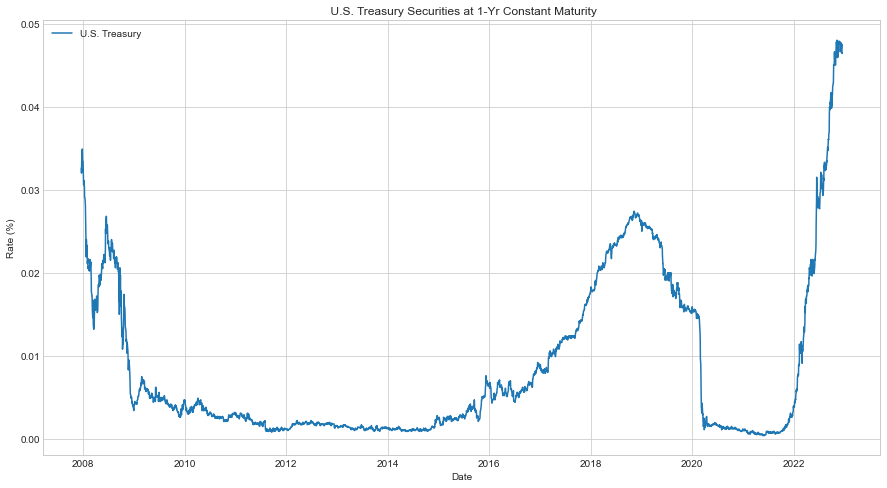

In [11]:
# Data interval (monthly)
interval = '1mo'
# Date of calculation
end = dt.datetime.today()
# start of calculation period (relative to end - "today:)
start = end - relativedelta(years=15)
# U.S. Treasury Securities at 1-Yr Constant Maturity
Rates = 'DGS1' #FRED
# Download data using pandas DataReader ('fred' for FRED data)
Rates = web.DataReader(Rates, 'fred', start, end)/100
Rates = Rates.dropna()
# Plots:
plt.plot(Rates.index, Rates['DGS1'])
plt.legend(['U.S. Treasury'])
plt.title(' U.S. Treasury Securities at 1-Yr Constant Maturity')
plt.ylabel('Rate (%)')
plt.xlabel('Date')
plt.show()

[*********************100%***********************]  2 of 2 completed


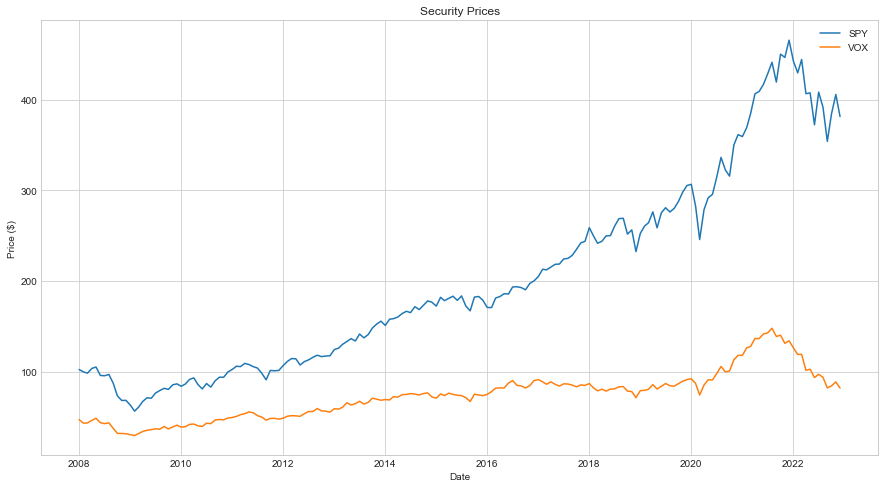

In [12]:
# Tickers from Yahoo! Finance
Tickers = ['SPY', 'VOX']
# Download data from Yahoo! (Adj Close to account for dividends and other corporate actions)
df = yf.download(Tickers, interval=interval, start=start)['Adj Close']
# Data into pandas dataframe
df = pd.DataFrame(df)
# Drop NaN (for non trading days)
df = df.dropna()

# Plots:
plt.plot(df.index, df['SPY'], df.index, df['VOX'])
plt.legend(['SPY', 'VOX'])
plt.title('Security Prices')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.show()

For returns, let's consider simple returns rather than log returns:

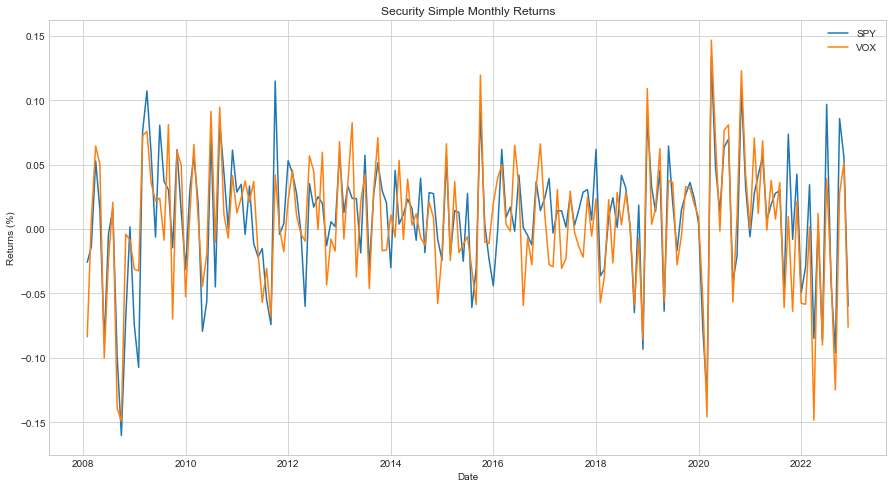

In [13]:
# Create a new DataFrame to calculate returns in continuous time
df1 = (df/df.shift(1)) - 1
# Drop first row (NaN)
df1 = df1[1::]
# Plot:
plt.plot(df1.index, df1['SPY'], df1.index, df1['VOX'])
plt.legend(['SPY', 'VOX'])
plt.title('Security Simple Monthly Returns')
plt.ylabel('Returns (%)')
plt.xlabel('Date')
plt.show()

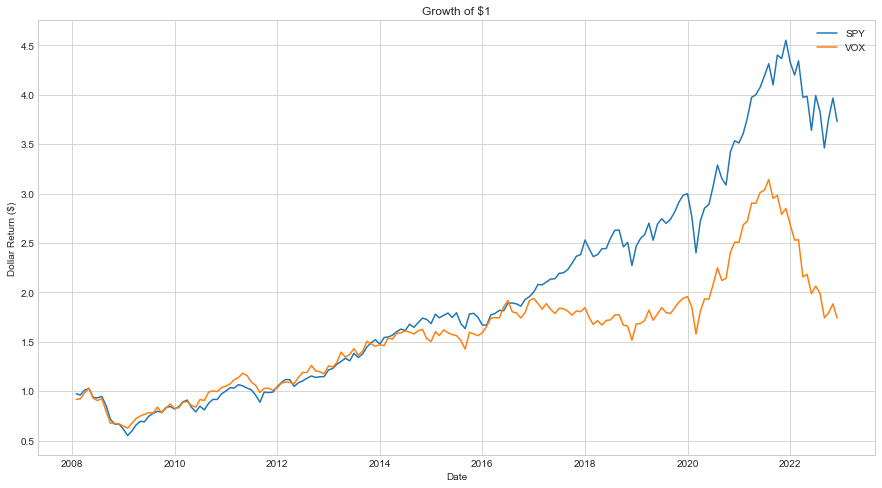

In [14]:
plt.plot(df1.index, (1*(1+df1['SPY']).cumprod()), df1.index, (1*(1+df1['VOX']).cumprod()))
plt.legend(['SPY', 'VOX'])
plt.title('Growth of $1')
plt.ylabel('Dollar Return ($)')
plt.xlabel('Date')
plt.show()

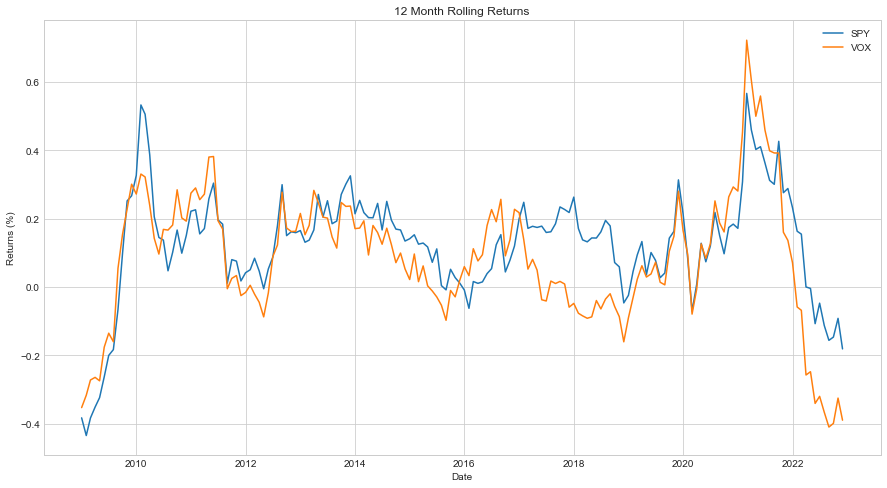

In [15]:
# Plot
plt.plot(df1.index, rolling_ret(df1['SPY'], 12) , df1.index, rolling_ret(df1['VOX'], 12))
plt.legend(['SPY', 'VOX'])
plt.title('12 Month Rolling Returns')
plt.ylabel('Returns (%)')
plt.xlabel('Date')
plt.show()

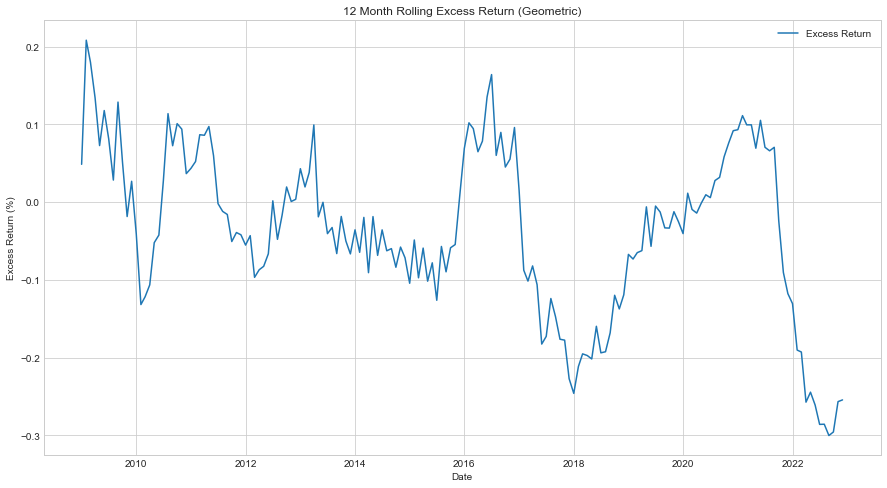

In [16]:
# Plot:
plt.plot(df1.index, rolling_excess(df1['VOX'], df1['SPY'], 12))
plt.legend(['Excess Return'])
plt.title('12 Month Rolling Excess Return (Geometric)')
plt.ylabel('Excess Return (%)')
plt.xlabel('Date')
plt.show()

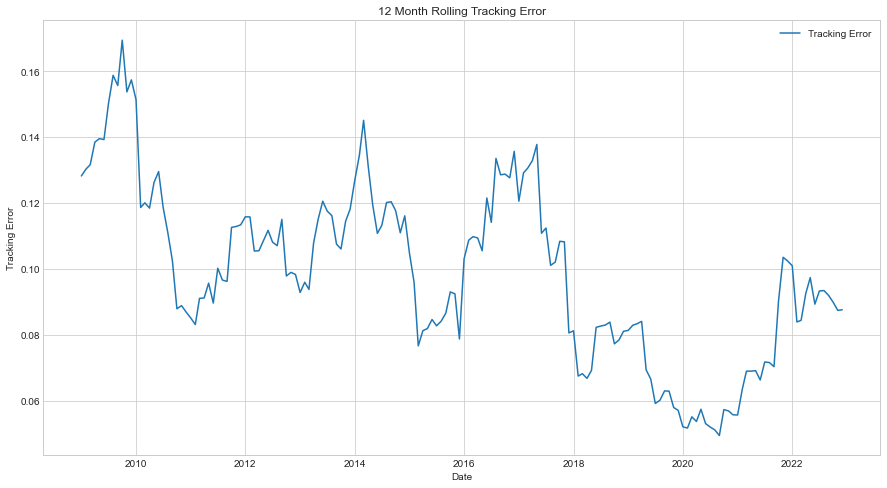

In [17]:
# Plot:
plt.plot(df1.index, rolling_te(df1['VOX'], df1['SPY'], 12))
plt.legend(['Tracking Error'])
plt.title('12 Month Rolling Tracking Error')
plt.ylabel('Tracking Error')
plt.xlabel('Date')
plt.show()

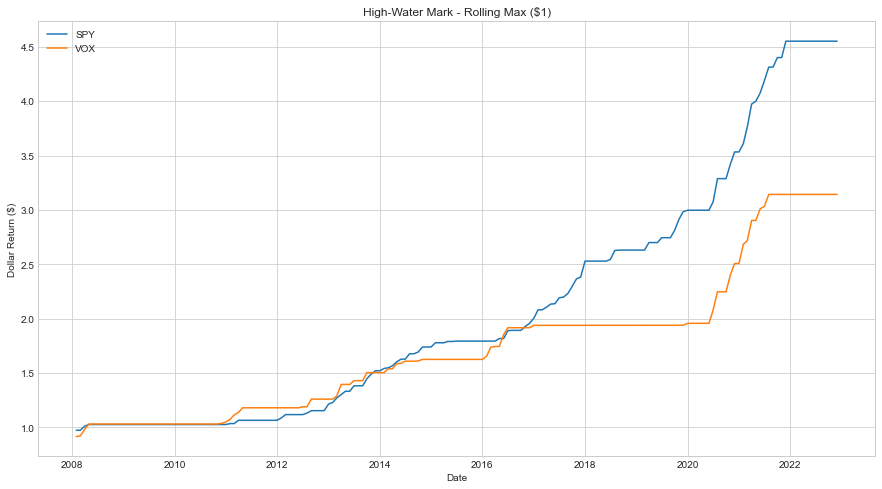

In [18]:
# Plot
plt.plot(df1.index, hwm(df1['SPY']) , df1.index, hwm(df1['VOX']))
plt.legend(['SPY', 'VOX'])
plt.title('High-Water Mark - Rolling Max ($1)')
plt.ylabel('Dollar Return ($)')
plt.xlabel('Date')
plt.show()

SPY Max Drawdown: -46.322%
VOX Max Drawdown: -44.63%


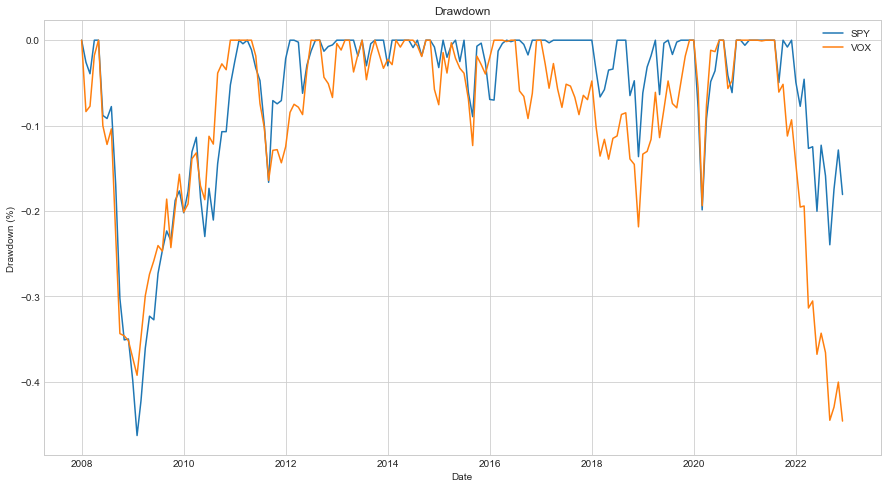

In [19]:
# Plot:
plt.plot(df.index, DD(df['SPY']), df.index, DD(df['VOX']))
plt.legend(['SPY', 'VOX'])
plt.title('Drawdown')
plt.ylabel('Drawdown (%)')
plt.xlabel('Date')
plt.show()

In [20]:
AR = [f"{round(an_returns(df1['SPY'])*100,3)}%", f"{round(an_returns(df1['VOX'])*100,3)}%"]
SD = [f"{round(an_vol(df1['SPY'])*100,3)}%", f"{round(an_vol(df1['VOX'])*100,3)}%"]
SHARPE = [round(sharpe(df1['SPY'], Rates),3), round(sharpe(df1['VOX'], Rates),3)]
TE = ['-', f"{round(TE(df1['VOX'], df1['SPY'])*10000,3)}bps"]
IR = ['-', round(info(df1['VOX'], df1['SPY']),3)]
BETA = ['-', round(beta(df1['VOX'], df1['SPY']),3)]
BA = ['-', f"{round(batting_average(df1['VOX'], df1['SPY'], 12)*100,3)}%"]
UC = ['-', f"{round(upside_capute(df1['VOX'], df1['SPY'])*100,3)}%"]
DC = ['-', f"{round(downside_capture(df1['VOX'], df1['SPY'])*100,3)}%"]
Metrics = [AR, SD, SHARPE, TE, IR, BETA, BA, UC, DC]
Metrics = pd.DataFrame(Metrics)
Metrics.columns = ['SPY - Benchamrk', 'VOX']
Metrics.insert(0,'Metrics',['Annualized Return', 'Annualized Volatility', 'Sharpe', 
                            'Tracking Error', 'Information Ratio', 'Beta', 'Batting Average',
                            'Upside Capture','Downside Capture'])
Metrics

,Metrics,SPY - Benchamrk,VOX
0,Annualized Return,9.223%,3.783%
1,Annualized Volatility,16.489%,17.479%
2,Sharpe,0.503,0.166
3,Tracking Error,-,1039.276bps
4,Information Ratio,-,-0.523
5,Beta,-,0.863
6,Batting Average,-,36.905%
7,Upside Capture,-,71.53%
8,Downside Capture,-,93.63%


________________________________________________________________________________________________________________________
###### Leonardo F. de Souza
###### 2022